<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/AMD_Progression/OpenCV/RPEDots2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mat4py
import matplotlib.pyplot as plt
import numpy as np
import h5py
from mat4py import loadmat

#data = loadmat('/content/2macula.mat')


In [3]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import matplotlib.image as mpimg
import cv2 as cv

#matfile = io.loadmat('/content/2macula.mat')


In [5]:

## This implementation is based on following research paper:
## https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf

This code is an implementation of [this research paper](https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf)


In [6]:
def show_img(img2show):
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()

In [7]:
## Apply denoising (Median Filters [23,24,37] )
## 3 × 3 pixels 
def apply_median_filter(in_img):
  filtered_img = cv.medianBlur(img, 3)
  #show_img(filtered_img)
  return filtered_img

In [8]:
## Apply K-Mean Clustering (Color Quantization)
def apply_k_mean_clustering(in_img):
  Z = in_img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((in_img.shape))
  return res2
  #cv.imshow('res2',res2)
  #show_img(res2)
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(res2)
  #plt.show()
  #cv.waitKey(0)
  #cv.destroyAllWindows()


In [9]:
### Apply Canny Edge Detector
def apply_canny_edge(in_img):
  edges = cv.Canny(in_img,50,200)

  return edges
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(edges)
  #plt.show()

In [10]:
def find_high_intensity_areas(in_img, th):
  resultr, resultc = [], []
  rows, cols = in_img.shape
  for col in range(cols):
    for row in range(rows):
      if in_img[row, col] > th:
        #temp = (row, col)
        resultr.append(row)
        resultc.append(col)
      
  return (resultr, resultc)

In [11]:
## Detect position of ILM
def detect_ilm(in_img):
  #print(edges.shape) ## 390, 508 ==> Rows x Cols
  rows, cols = in_img.shape
  center = cols//2
  center += 50
  ilm_pos = []
  ilm_dict = dict()
  seg_img = np.zeros((rows, cols), np.uint8)
  prev_row = 0
  for col in range(center, cols):
    for row in range(rows):
      if in_img[row, col] > 200 and (abs(prev_row - row) < 5 or prev_row == 0):
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_dict[col] = row
        ilm_pos.append(pos)
        #print("In the loop", row, col)
        prev_row = row
        break

  prev_row = 0
  for col in range(center-1, -1, -1):
    for row in range(rows):
      if in_img[row, col] > 200 and (abs(prev_row - row) < 5 or prev_row == 0):
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_pos.append(pos)
        ilm_dict[col] = row
        #print("In the loop", row, col)
        prev_row = row
        break
  
  
  return ilm_pos, ilm_dict
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(seg_img)
  #plt.show()

In [12]:
## now we know that 
def find_RPE_col(rows, cols, in_loc):
  rpe_pos = []
  counter = 0

  for r in rows:
    if r == in_loc:
      break
    counter += 1

  return cols[counter]

## here we know the index of high intensity row



In [13]:
#(hi_rows, high_cols) = find_high_intensity_areas(gray)
#print(hi_rows.median())

In [14]:
#gray = cv.cvtColor(filtered_img, cv.COLOR_BGR2GRAY)
# perform a naive attempt to find the (x, y) coordinates of
# the area of the image with the largest intensity value
#(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(gray)
#cv.circle(img_ilm, maxLoc, 5, (255, 0, 0), 2)


In [15]:
def segment_rpe1(gray_img, rpe_col, rpe_row, t_cols):
  rpe_pos = []
  rpe_dict = dict()
  sliding_row = rpe_row
  temp1 = (sliding_row, rpe_col)
  max_rows, max_cols = gray_img.shape
  rpe_dict[rpe_col] = sliding_row
  rpe_pos.append(temp1)
  int_thr = 170
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  ### Use these rows to track previous two values of rows
  ## next row should be prev_row1 + (prev_row1 - prev_row2)
  prev_pos_tracker = 0
  for c in range(rpe_col-1, 0, -1):
    
    for index in range(1, 10):
      flag = 0
      if sliding_row + index < max_rows:
        max_val  = gray_img[sliding_row+index, c]
        max_index = sliding_row + index
      

        if gray_img[sliding_row + index, c] > int_thr:
            if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
              sliding_row += index
              temp = (sliding_row, c)
              rpe_dict[c] = sliding_row
              rpe_pos.append(temp)
              flag = 1
              break

      #if gray_img[sliding_row - index, c] > max_val:
       # max_val  = gray_img[sliding_row-index, c]
       # max_index = sliding_row - index

      if gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    #if prev_pos_tracker % 3 == 1:
    
      
    #elif prev_pos_tracker % 3 == 2:
    prev_row2 = prev_row1
    prev_row1 = sliding_row

    

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)
      
  sliding_row = rpe_row
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  for c in range(rpe_col, t_cols):
    for index in range(1, 10):
      '''
      if sliding_row + index < t_cols:
        val = gray_img[sliding_row + index, c]
        #print(val)
        if val > max_val:
          max_val = gray_img[sliding_row + index, c]
          max_index = sliding_row + index

      if sliding_row - index >= 0:
        val = gray_img[sliding_row - index, c]
        if gray_img[sliding_row - index, c] > max_val:
          max_val = gray_img[sliding_row - index, c]
          max_index = sliding_row - index
      '''
      flag = 0
      if sliding_row + index < max_rows:
        if gray_img[sliding_row + index, c] > int_thr:
          if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
            sliding_row += index
            temp = (sliding_row, c)
            rpe_dict[c] = sliding_row
            rpe_pos.append(temp)
            flag = 1
            break

      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    prev_row2 = prev_row1
    prev_row1 = sliding_row

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)

      
  
  return rpe_pos, rpe_dict

In [16]:
def segment_rpe1(gray_img, rpe_col, rpe_row, t_cols):
  rpe_pos = []
  rpe_dict = dict()
  sliding_row = rpe_row
  temp1 = (sliding_row, rpe_col)
  rpe_dict[rpe_col] = sliding_row
  rpe_pos.append(temp1)
  int_thr = 170
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  ### Use these rows to track previous two values of rows
  ## next row should be prev_row1 + (prev_row1 - prev_row2)
  prev_pos_tracker = 0
  for c in range(rpe_col-1, 0, -1):
    
    for index in range(1, 10):
      flag = 0
      max_val  = gray_img[sliding_row+index, c]
      max_index = sliding_row + index
      '''
      if sliding_row + index < t_cols:
        val = gray_img[sliding_row + index, c]
        print(val)
        if val > max_val:
          max_val = gray_img[sliding_row + index, c]
          max_index = sliding_row + index

      if sliding_row - index >= 0:
        val = gray_img[sliding_row - index, c]
        if gray_img[sliding_row - index, c] > max_val:
          max_val = gray_img[sliding_row - index, c]
          max_index = sliding_row - index
      
      
      temp = (max_index, c)
      rpe_dict[c] = max_index
      rpe_pos.append(temp)
      
      if gray_img[sliding_row + index, c] > max_val:
        max_val  = gray_img[sliding_row+index, c]
        max_index = sliding_row + index
      '''

      if gray_img[sliding_row + index, c] > int_thr:
        if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
          sliding_row += index
          temp = (sliding_row, c)
          rpe_dict[c] = sliding_row
          rpe_pos.append(temp)
          flag = 1
          break

      #if gray_img[sliding_row - index, c] > max_val:
       # max_val  = gray_img[sliding_row-index, c]
       # max_index = sliding_row - index

      if gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    #if prev_pos_tracker % 3 == 1:
    
      
    #elif prev_pos_tracker % 3 == 2:
    prev_row2 = prev_row1
    prev_row1 = sliding_row

    

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)
      
  sliding_row = rpe_row
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  for c in range(rpe_col, t_cols):
    for index in range(1, 10):
      '''
      if sliding_row + index < t_cols:
        val = gray_img[sliding_row + index, c]
        #print(val)
        if val > max_val:
          max_val = gray_img[sliding_row + index, c]
          max_index = sliding_row + index

      if sliding_row - index >= 0:
        val = gray_img[sliding_row - index, c]
        if gray_img[sliding_row - index, c] > max_val:
          max_val = gray_img[sliding_row - index, c]
          max_index = sliding_row - index
      '''
      flag = 0
      if gray_img[sliding_row + index, c] > int_thr:
        if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
          sliding_row += index
          temp = (sliding_row, c)
          rpe_dict[c] = sliding_row
          rpe_pos.append(temp)
          flag = 1
          break

      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    prev_row2 = prev_row1
    prev_row1 = sliding_row

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)

      
  
  return rpe_pos, rpe_dict

In [17]:
def return_avg(starting_index, col_val, hi_cols, hi_rows):
  counter = sum = 0
  while hi_cols[starting_index] == col_val:
    sum += hi_rows[starting_index]
    starting_index += 1
    counter += 1
    if starting_index < len(hi_cols):
      break

  return sum//counter, starting_index

In [50]:
def segment_rpe(hi_rows, hi_cols, size):
  rpe_pos = []
  rpe_dict = dict()
  c_index = 0
  col_ptr = 0
  prev_row = 0

  for c_index in range(0, size):
    #while high_cols[c_index] == c_index:
    while col_ptr < len(hi_cols) and hi_cols[col_ptr] == c_index:
      col_ptr += 1
    temp = hi_rows[col_ptr-1], c_index
    rpe_pos.append(temp)
    rpe_dict[c_index] = hi_rows[col_ptr-1]
    '''
    if col_ptr < len(hi_cols) and hi_cols[col_ptr] == c_index: ## this column has certain bright spots
      aveg, ending_index = return_avg(col_ptr, c_index, hi_cols, hi_rows)
      prev_row = aveg
    
    else:
      aveg = prev_row
      temp = aveg, c_index
      rpe_pos.append(temp)
      rpe_dict[c_index] = aveg
      col_ptr += 1
    '''
  return rpe_pos, rpe_dict



In [55]:
def estimate_rpe(bm_pos_curve, rpe_pos_curve):
  counter = 350

  ## starting from this counter:
  ## Phase-I ==> replace rpe pos with bm_pos_curve
  ## Plus do the same for first 50 cols
  ##########################################
  ## Phase-II ==> Check the difference in both curves and make decision

  r,c = bm_pos_curve[counter]

  print("Row col", r, c)


In [19]:
def find_starting_row_fluid(ilm_dict, counter):
  if counter in ilm_dict:
      starting_row = ilm_dict[counter] + 15
      return starting_row
  else:
    for i in range(10):
      if counter-i in ilm_dict:
        starting_row = ilm_dict[counter-i]
        return starting_row

      elif counter+i in ilm_dict:
        starting_row = ilm_dict[counter+i]
        return starting_row

  return -999


In [20]:
def find_ending_row_fluid(rpe_dict, counter):
  if counter in rpe_dict:
      starting_row = rpe_dict[counter]
      return starting_row
  else:
    for i in range(150):
      if counter-i in rpe_dict:
        starting_row = rpe_dict[counter-i]
        return starting_row

      elif counter+i in rpe_dict:
        starting_row = rpe_dict[counter+i]
        return starting_row

  return -99


In [34]:
def seg_fluid(gray_img, ilm_pos, rpe_pos, thershld, thershld2, ilm_dict, rpe_dict):
  ## length of rows should be equal to number of cols
  ilm_rows, ilm_cols, rpe_rows, rpe_cols = [],[],[],[]
  MAX_ROW, MIN_ROW = 0,0
  NUM_ROWS, NUM_COLS = gray_img.shape
  fluid_pos = []

  for ilms in ilm_pos:
    (row, col) = ilms
    ilm_rows.append(row)
    ilm_cols.append(col)

  for rpes in rpe_pos:
    (row, col) = rpes
    rpe_rows.append(row)
    rpe_cols.append(col)

  MAX_ROW = max(rpe_rows)
  MIN_ROW = min(ilm_rows)

 # print(len(ilm_rows))
  #print(gray_img.shape)

  counter = -1
  prev_ending_row = MAX_ROW
  prev_starting_row = MIN_ROW

  for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    if ending_row == -99 or ending_row is None:
      ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row
      
    while starting_row <= ending_row:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      #print("Starting row is",starting_row)
      r = starting_row
      if gray_img[r, c] > thershld and gray_img[r, c] < thershld2:
        temp = (r, c)
        #resultr.append(row)
        fluid_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row

  return fluid_pos, MAX_ROW, MIN_ROW


In [22]:
def seg_fluid1(gray_img, ilm_pos, rpe_pos, thershld, thershld2, ilm_dict, rpe_dict):
  ## length of rows should be equal to number of cols
  ilm_rows, ilm_cols, rpe_rows, rpe_cols = [],[],[],[]
  MAX_ROW, MIN_ROW = 0,0
  NUM_ROWS, NUM_COLS = gray_img.shape
  fluid_pos = []

    for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    if ending_row == -99 or ending_row is None:
      ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row
      
    while starting_row <= ending_row:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      r = starting_row
      if gray_img[r, c] > thershld and gray_img[r, c] < thershld2:
        temp = (r, c)
        #resultr.append(row)
        fluid_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row




  return fluid_pos

IndentationError: ignored

In [23]:
def remove_intensity_outliers1(ilm_mode, ilm_dict, hi_r, hi_c):
  new_rows, new_cols = [],[]
  index = 0
  PIXEL_DIFF_TH, th2 = 35, 20
  IMP_COL = 100
  #print("ILM MODE ", ilm_mode)
  '''
  for c in hi_c:
    ## in each column, remove two outliers
    ## (i) values above ilm
    ## (ii) values 30 pixel under that point
    if index in ilm_dict:
      if ilm_dict[index] > hi_r[index]:
        continue

      #if abs(ilm_dict[index] - hi_r[index]) < 30:
       # continue

      new_rows.append(c)
      new_cols.append(hi_r[index])


  '''
  for r in hi_r:
    
    if index > len(hi_c):
      continue

    if IMP_COL in ilm_dict:
      if abs(r - ilm_dict[IMP_COL]) < th2:
        continue
    #if index in ilm_dict:
     # print("Row from intensity , ILM and Column", r, ilm_dict[index], index)
      #if r > ilm_dict[index] or abs(r-ilm_dict[index]) < 40:
       # continue

    if abs(r - ilm_mode) > PIXEL_DIFF_TH:
      new_rows.append(r)
      new_cols.append(hi_c[index])

    index += 1
    

  return new_rows, new_cols

In [24]:
def remove_extremes(new_rows, new_cols):
  rows, cols = [], []
  r_mode = stats.mode(new_rows)
  r_mode = r_mode[0][0]

  for i in range(0, len(new_rows)):
    if r_mode - new_rows[i] > 70:
      continue
    rows.append(new_rows[i])
    cols.append(new_cols[i])
  
  return rows, cols

In [25]:
def remove_intensity_outliers(ilm_mode, ilm_dict, hi_r, hi_c):
  new_rows, new_cols = [],[]
  #index = 0
  PIXEL_DIFF_TH, th2 = 50, 20
  IMP_COL = 100

  for index in range(0, len(hi_r)):
    c = hi_c[index]
    r = hi_r[index]
    flag = 0
    #print(c,r)
    if c in ilm_dict:
      if (r - ilm_dict[c]) < PIXEL_DIFF_TH:
        flag = 1
    else:
      for i in range(1,6):
        new_c = index + i
        if new_c in ilm_dict:
          if (r - ilm_dict[new_c]) < PIXEL_DIFF_TH:
            flag = 1

        new_c = index - i
        if new_c in ilm_dict:
          if (r - ilm_dict[new_c]) < PIXEL_DIFF_TH:
            flag = 1
    
    if flag == 1:
      continue
        
    #print("Vals appended", index)
    new_rows.append(r)
    new_cols.append(c)
    
#   index += 1

  new_rows, new_cols = remove_extremes(new_rows, new_cols)

  return (new_rows, new_cols)


In [26]:
from scipy import stats

def return_vals(my_dict):
  vals = []
  for key in my_dict:
    vals.append(my_dict[key])

  return vals

In [27]:
from collections import Counter 

def estimate_rpe1(new_hi_rows, new_hi_cols, rpe_col):
  r_mode = stats.mode(new_hi_rows)
  countes = Counter(new_hi_rows) 
  second_frq = countes.most_common(2)[0][0]
  r_mode = r_mode[0][0]
  s_index = 0
  prev1, prev2 = 0,0
  for r in new_hi_rows:
    if r == second_frq:
      break
    s_index += 1

  last = len(new_hi_cols) - 1
  second = max(rpe_col, s_index)
  first = min(rpe_col, s_index)
  
  ## last part
  prev2 = new_hi_rows[second]
  prev1 = new_hi_rows[second + 1] ## moving to the right first

  

  ## now we know the index from where to start
  for i in range(second+2, ):
    if abs(prev1 - new_hi_rows[i]) > 10:  ## outlier
      new_hi_rows[i] = prev1 + (prev2 - prev1)
    prev2 = prev1
    prev1 = new_hi_rows[i]

  ## second last

  prev2 = new_hi_rows[second]
  prev1 = new_hi_rows[second - 1] ## moving to left

  for i in range(second-2, first-1, -1):
    if abs(prev1 - new_hi_rows[i]) > 10:  ## outlier
      new_hi_rows[i] = prev1 + (prev2 - prev1)
    prev2 = prev1
    prev1 = new_hi_rows[i]

  ## first part

  prev2 = new_hi_rows[first]
  prev1 = new_hi_rows[first - 1] ## moving to left

  for i in range(first-2, -1, -1):
    if abs(prev1 - new_hi_rows[i]) > 10:  ## outlier
      new_hi_rows[i] = prev1 + (prev2 - prev1)
    prev2 = prev1
    prev1 = new_hi_rows[i]



  return new_hi_rows, new_hi_cols



In [42]:
def seg_foci(gray_img, thershld_min, thershld_max, ilm_dict, rpe_dict, MAX_ROW, MIN_ROW, RPE_ROW):
  ## length of rows should be equal to number of cols

  ## another algorithm
  ## detect the bright clusters (Spots) first
  ## pick those clusters having area of less than ___
  ## only those which are below ILM and above RPE
  
  NUM_ROWS, NUM_COLS = gray_img.shape
  foci_pos = []

  print("rows and cols are ", NUM_ROWS, NUM_COLS)
  
  counter = -1
  prev_ending_row = MAX_ROW
  prev_starting_row = MIN_ROW

  ending_row = prev_ending_row

  for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    #if ending_row == -99 or ending_row is None:
    ##  ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row

    starting_row += 20
    ending_row -= 20
      
    while starting_row <= ending_row and starting_row < NUM_ROWS:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      #print("Starting row is",starting_row)
      r = starting_row
      #if abs(r - RPE_ROW) < 10:
      #  continue
      
      if gray_img[r, c] > thershld_min and gray_img[r, c] < thershld_max:
        temp = (r, c)
        #resultr.append(row)
        foci_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row

  return foci_pos

Size of dictionaries  508 508 508
Row col 185 350
rows and cols are  390 508


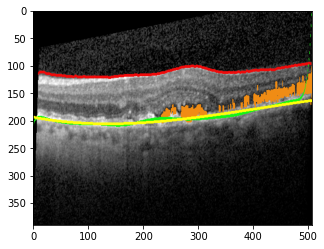

In [54]:
import os
#from scipy.interpolate import spline
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression

MIN_ROW = 10
MAX_ROW = 400


os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
image_files = os.listdir()
#os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
#for img_name in image_files:
#img_name = image_files[25]
#img = img[MIN_ROW:MAX_ROW,500:,:]
#new_name = 'cropped_'+img_name
#cv.imwrite(new_name, img)

### THE PROBLEM IS WITH DETECTION OF ILM ---> FIX THAT --> OUTLIERS ARE BEING MARKED
for img_name in image_files:
  min_thrshld, max_thrshld = 0, 50 ## TODO-1 MAKE THESE INTENSITIES DYNAMIC
  RANGE_THRESHOLD = 145
  foci_mn_th, foci_mx_th = 210, 255
  RPE_THR = 200
  #img_name = image_files[2]
  #img_name = 'cropped_JB016.bmp'
  img = cv.imread(img_name)
  #img = resize_img(img)
  md_img = apply_median_filter(img)
  clus_img = apply_k_mean_clustering(md_img)
  ed_img = apply_canny_edge(clus_img)
  ilm_pos, ilm_dict = detect_ilm(ed_img)
  #print("Length of ILM Dict", len(ilm_dict), ed_img.shape)
  #print("Length is ", len(ilm_dict), img_name)
  
  ## detecting RPE
  gray = cv.cvtColor(md_img, cv.COLOR_BGR2GRAY)
  vals = return_vals(ilm_dict)
  ilm_mode = stats.mode(vals)
  ilm_mode = ilm_mode[0][0]
  #print("ILM MODE VALS ",ilm_mode)
  #print(np.mean(gray))
  if np.mean(gray) < 51:
    RPE_THR -= 20
    max_thrshld -= 10
  if np.mean(gray) < 43:
    RPE_THR -= 20
    max_thrshld -= 10
  #print(np.mean(gray), RPE_THR, max_thrshld)
  (hi_rows, high_cols) = find_high_intensity_areas(gray, RPE_THR)
  #print("RPE VALS ",hi_rows)
  #print(ilm_mode)
  #print(ilm_dict)
  #print(len(ilm_dict))
  #print(len(hi_rows)) 
  #print(len(high_cols))
  #print(high_cols)

  (hi_rows, high_cols) = remove_intensity_outliers(ilm_mode, ilm_dict, hi_rows, high_cols)
  '''
  rpe_func = interp1d(high_cols, hi_rows, fill_value='extrapolate', kind='cubic')
  new_hi_rows, new_hi_cols = [],[]
  print("Shape of gray ", gray.shape)
  for c in range(0, gray.shape[1]-1):
    print("X NEw is ", c)
    r = rpe_func(c)
    new_hi_rows.append(r)
    new_hi_cols.append(c)
  '''
  #print(ilm_mode)
  #print(ilm_dict)
  #print(hi_rows) 
  #print(high_cols)
  #print("RPE VALS ",hi_rows)
  #plt.imshow(gray)
  #plt.show()
  T_COLS = gray.shape[1]
  mode = stats.mode(hi_rows)
  rpe_row = mode[0][0]
  #print("RPE Rows and Cols are", len(hi_rows), len(high_cols))
  rpe_col = find_RPE_col(hi_rows, high_cols, rpe_row) 
  #f2 = interp1d(x, y, kind='cubic')
  #print("Size of image is ", gray.shape[1])
  rpe_pos, rpe_dict = segment_rpe(hi_rows, high_cols, gray.shape[1])

  new_hi_rows, new_hi_cols = [],[]
  
  for pos in rpe_pos:
    r,c = pos
    new_hi_rows.append(r)
    new_hi_cols.append(c)


  rpe_pos = []
  #rpe_dict = dict()
  for i in range(0, len(high_cols)):
    temp = hi_rows[i], high_cols[i]
    rpe_pos.append(temp)

  z = np.polyfit(high_cols, hi_rows, 15)      ## need to use this for Foci segmentation
  bm = np.polyfit(high_cols, hi_rows, 3)      ## need to use this for fluid segmentation
  ft_or = np.polyfit(high_cols, hi_rows, 5)
  rpe_equation = np.poly1d(z)
  bm_equation = np.poly1d(bm)
  fo_equation = np.poly1d(ft_or)

  rpe_pos_curve = []
  rpe_pos_curve_dict = dict()                 ## pass this dict to Foci segmentation
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    curve_row = int(rpe_equation(i))
    temp = curve_row, i
    rpe_pos_curve.append(temp)
    rpe_pos_curve_dict[i] = curve_row

  bm_pos_curve = []
  bm_pos_curve_dict = dict()                  ## pass this dict to Fluid segmentation
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    bm_row = int(bm_equation(i))
    temp = bm_row, i
    bm_pos_curve.append(temp)
    bm_pos_curve_dict[i] = bm_row

  fo_pos_curve = []
  fo_pos_curve_dict = dict()
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    fo_row = int(fo_equation(i))
    temp = fo_row, i
    fo_pos_curve.append(temp)
    fo_pos_curve_dict[i] = fo_row

  print("Size of dictionaries ", len(fo_pos_curve_dict), len(bm_pos_curve_dict), len(rpe_pos_curve_dict))


  ## This estimate function is taking bright points and returning average of it ==> Line Curve
  #(new_hi_rows, new_hi_cols) = estimate_rpe(new_hi_rows, new_hi_cols, rpe_col)

  '''
  new_rpe_pos = []
  new_rpe_dict = dict()
  for i in range(T_COLS-1):
    #print("Col and Predicted Row", i, row_new)
    row_new = new_hi_rows[i]
    col_new = new_hi_cols[i]
    temp = (row_new, col_new)
    new_rpe_pos.append(temp)
    new_rpe_dict[col_new] = row_new
  '''
  #rpe_pos, rpe_dict = segment_rpe(gray, rpe_col, rpe_row, gray.shape[1])
  #print(rpe_dict)

  segmented_rpe_pos = estimate_rpe(bm_pos_curve, rpe_pos_curve)
  
 # new_rows, new_cols = [], []
#  for i in range(0, gray.shape[1]):
#    new_rows.append(rpe_dict[i])
 #   new_cols.append(i)
  
  #clf = LogisticRegression(random_state=0).fit(new_cols, new_rows)


  #print(len(new_cols))
  #rpe_func = interp1d(new_cols, new_rows, fill_value='extrapolate', kind='cubic')
  '''
  new_hi_rows, new_hi_cols = [],[]
  #print("Shape of gray ", gray.shape)
  for pos in rpe_pos:
    #print("X NEw is ", c)
  #  r = int(rpe_func(c))
    r,c = pos
    new_hi_rows.append(r)
    new_hi_cols.append(c)


  (new_hi_rows, new_hi_cols) = estimate_rpe(new_hi_rows, new_hi_cols, rpe_col)
  #print("Col Row ", new_hi_cols.shape, len(new_hi_rows))
  new_hi_cols = np.expand_dims(new_hi_cols, axis=1)
  print("Col Row ", new_hi_cols.shape, len(new_hi_rows))
  clf = LogisticRegression(max_iter=5000).fit(new_hi_cols, new_hi_rows)
  
  new_rpe_pos = []
  new_rpe_dict = dict()
  n = T_COLS
  col_vals = list(range(0, n))
  col_vals = np.expand_dims(col_vals, axis=1)
  predicted_rows = clf.predict(col_vals)
  for i in range(T_COLS-1):
    row_new = predicted_rows[i]
    #print("Col and Predicted Row", i, row_new)
    temp = (row_new, i)
    new_rpe_pos.append(temp)
    new_rpe_dict[i] = row_new
  '''
  ## detecting Fluid
  #print(rpe_dict.keys())
  #print("Length of RPE Dict is ",len(rpe_dict))
  #print(rpe_pos)
  fluid_pos, mx_row, mn_row = seg_fluid(gray, ilm_pos, rpe_pos, min_thrshld, max_thrshld, ilm_dict, bm_pos_curve_dict)

  foci_pos = seg_foci(gray, foci_mn_th, foci_mx_th, ilm_dict, rpe_pos_curve_dict, mx_row, mn_row, rpe_row)

  #count, th = 1, 10
  segmented_scan_ilm_rpe_final = img.copy()

  for ilm_position in ilm_pos:
    (row, col) = ilm_position
    segmented_scan_ilm_rpe_final[row:row+5, col, 0] = 240
    segmented_scan_ilm_rpe_final[row:row+5, col, 1] = 10
    segmented_scan_ilm_rpe_final[row:row+5, col, 2] = 10


  for f in fluid_pos:
    (row_f, col_f) = f
    segmented_scan_ilm_rpe_final[row_f:row_f+10, col_f, 2] = 20
    segmented_scan_ilm_rpe_final[row_f:row_f+10, col_f, 1] = 140
    segmented_scan_ilm_rpe_final[row_f:row_f+10, col_f, 0] = 240

  for rpe_position in rpe_pos_curve:
    (row_r, col_r) = rpe_position
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 1] = 245
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 0] = 20
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 2] = 20
    #segmented_scan_ilm_rpe_final[row_r+1, col_r, 1] = 255
    #segmented_scan_ilm_rpe_final[row_r+2, col_r, 1] = 255
    #segmented_scan_ilm_rpe_final[row_r+3, col_r, 1] = 255
    #segmented_scan_ilm_rpe_final[row_r+4, col_r, 1] = 255

  
  for bm_position in bm_pos_curve:
    (row_r, col_r) = bm_position
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 1] = 255
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 0] = 255
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 2] = 10
  

  for fc in foci_pos:
    (row_r, col_r) = fc
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 1] = 64
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 0] = 235
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 2] = 230

  fig = plt.figure(figsize=(5, 5))

  plt.imshow(segmented_scan_ilm_rpe_final)
  plt.show()

  
  output_file_path = "/content/drive/My Drive/Colab Notebooks/AMD/New Results/"+img_name
  #cv.imread(img_name)
  #cv.imwrite(output_file_path, segmented_scan_ilm_rpe_final)

  break


In [ ]:
def resize_img(in_img):
  scale_percent = 30 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  new_dim = (width, height)

  resized = cv.resize(in_img, new_dim, interpolation = cv.INTER_AREA)

  return resized